In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import pathlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [3]:
import sys
sys.path.append('../..')
import lared.accel.constants.constants as const
from lared.constants.laughter_constants import data_path, cloud_data_path
from modules.accel.preproc import interpolate

In [4]:
cloud_data_path

'/mnt/c/Users/Jose/gdrive/data/lared_laughter'

In [5]:
DATA_ROOT = pathlib.Path("/mnt/e/data/lared")
CHALCEDONY_ROOT = DATA_ROOT / "accel"
MAPPING_FILE    = CHALCEDONY_ROOT / "mapping.csv"
MASTER_PICKLE_PATH = CHALCEDONY_ROOT / "master_data.pkl"
VALID_AUDIO_SEGMENTS_PATH = "./valid_audio_segments.pkl"

accel_ds_path = os.path.join(cloud_data_path, 'accel', 'accel_ds_human.pkl')

# Interpolation

In [6]:
balloon_pop_1_video_frame = 23030 # to 
balloon_pop_1_accel_frame = 45977 + 19/34

balloon_pop_2_video_frame = 74844
balloon_pop_2_accel_frame = 47706 + 23/28

balloon_pop_3_video_frame = 166836.5
balloon_pop_3_accel_frame = 50776 + 30.5/32

frame_to_accel = interp1d([balloon_pop_1_video_frame, balloon_pop_3_video_frame], [balloon_pop_1_accel_frame, balloon_pop_3_accel_frame], fill_value="extrapolate")
video_seconds_to_accel_sample = interp1d([balloon_pop_1_video_frame/29.97, balloon_pop_3_video_frame/29.97], [balloon_pop_1_accel_frame, balloon_pop_3_accel_frame], fill_value="extrapolate")

In [7]:
# load the array to map from PID to node ID
mapping_arr = np.loadtxt(MAPPING_FILE, delimiter=',',dtype=int)
keys = mapping_arr[:,1]
vals = mapping_arr[:,0]
mapping = dict(zip(keys,vals))

In [8]:
# load the accel stuff
master_df = pd.read_pickle(str(MASTER_PICKLE_PATH))

In [9]:
valid_seg = pickle.load(open(VALID_AUDIO_SEGMENTS_PATH,'rb'))
valid_seg = [el[1] for el in valid_seg]
pid_to_valid_seg = {el[0]: (video_seconds_to_accel_sample(el[1]/1000).item(), video_seconds_to_accel_sample(el[2]/1000).item()) for el in valid_seg}

# Extracting accel per subject
Mapping from pid to accel

In [10]:
grouped_df = master_df.groupby('Node')
subj_accel = dict()
for name, group in grouped_df:
    
    if name not in mapping:
        print('{:d} not in mapping'.format(name))
        continue
        
    pid = mapping[name]
    print((name, pid))
    
    if pid not in pid_to_valid_seg:
        print('{:d} not in pid_to_valid_seg'.format(pid))
        continue
    subj_valid_seg = pid_to_valid_seg[pid]
    
    if name in const.FAILED_ACCEL:
        print('failed accel for pid {:d}'.format(pid))
        continue
    
    def assert_len(x):
        assert len(x) == 20
        
    frame_nums = group['Frame_No'].to_numpy()
    diffs = np.diff(frame_nums)
#     print(diffs[~np.isclose(diffs,1)])
    first_idx = np.argmax(diffs) # find when the sync jump occurs
#     first_idx = np.argmax(frame_nums > 40000)
        
    group['x'].apply(assert_len)
    group['y'].apply(assert_len)
    group['z'].apply(assert_len)
    
    t = np.concatenate([np.arange(t, t+1, 0.05) for t in frame_nums])
    x = np.concatenate(group['x'].tolist())
    y = np.concatenate(group['y'].tolist())
    z = np.concatenate(group['z'].tolist())
        
    accel = np.hstack([t[:,None],x[:,None],y[:,None],z[:,None]])[(first_idx+1)*20:,:]
    accel = accel[(accel[:,0] > subj_valid_seg[0]) & (accel[:,0] < subj_valid_seg[1]), :] # filter out accel out of valid segment
    
    # Normalization per subject
    accel[:,1:] = StandardScaler().fit_transform(accel[:,1:])
    
    interp_accel = interpolate(accel, 0.05)
    print((len(accel), len(interp_accel)))
    subj_accel[pid] = accel

2 not in mapping
(3, 21)
failed accel for pid 21
(4, 22)
(88642, 88642)
(5, 8)
8 not in pid_to_valid_seg
(7, 10)
(112240, 112240)
(9, 34)
(64027, 64027)
(12, 33)
(48518, 48518)
(13, 27)
(49781, 49781)
(14, 9)
failed accel for pid 9
16 not in mapping
18 not in mapping
(21, 5)
(113188, 113188)
(22, 15)
(109084, 109084)
23 not in mapping
(24, 17)
(103605, 103605)
(25, 26)
(90401, 90401)
26 not in mapping
(27, 24)
(141050, 141170)
29 not in mapping
(30, 14)
(104327, 104327)
(32, 2)
(121658, 121678)
(33, 39)
39 not in pid_to_valid_seg
(34, 16)
(26598, 26598)
(43, 30)
(96951, 97031)
(44, 7)
(144877, 144957)
(46, 23)
(150967, 151127)
49 not in mapping
(50, 1)
failed accel for pid 1
52 not in mapping
54 not in mapping
(55, 12)
(83582, 83582)
56 not in mapping
57 not in mapping
(62, 19)
(40979, 40979)
64 not in mapping
(65, 38)
38 not in pid_to_valid_seg
(68, 11)
(92457, 92457)
73 not in mapping
(75, 3)
(122628, 122628)
76 not in mapping
78 not in mapping
(79, 35)
(98125, 98125)
(80, 32)
(83920

In [11]:
len(subj_accel)
subj_accel.keys()

dict_keys([22, 10, 34, 33, 27, 5, 15, 17, 26, 24, 14, 2, 16, 30, 7, 23, 12, 19, 11, 3, 35, 32, 18, 31, 4])

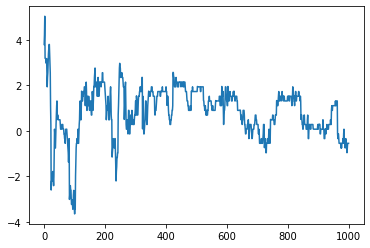

In [12]:
a = subj_accel[22]
plt.plot(a[50000: 51000, 1])

# Extracting accel for examples

In [13]:
examples = pd.read_csv('../annotation/analysis/annotation_results.csv')
examples = examples.groupby('hash').agg({
    'hash': 'first',
    'cam': 'first',
    'person': 'first',
    'ini_time': 'first',
    'end_time': 'first',
    '_ini_time': 'first',
    '_end_time': 'first',
})

In [14]:
examples.head()

,hash,cam,person,ini_time,end_time
hash,,,,,
002043005fa746f076c845dc38dd1bd97327bde09e17fcb953102c7ff0b277ac,002043005fa746f076c845dc38dd1bd97327bde09e17fc...,2,9,7963.610000,7965.490000
006f74addfc99845bf6c9f80d13d52ccc189341031525530762bb83dd8b713af,006f74addfc99845bf6c9f80d13d52ccc1893410315255...,4,30,8289.657000,8292.107000
0070b1ba6e8de828aea5c6d3b9d1c3662959fb5f032a679cac78e5ca98fcb1ff,0070b1ba6e8de828aea5c6d3b9d1c3662959fb5f032a67...,1,22,1996.955000,2000.122000
00bcb7cfe796c64cf5fa4195248553f4a5937897650cee2e2bc2d80fba782667,00bcb7cfe796c64cf5fa4195248553f4a5937897650cee...,3,22,3700.565000,3701.599000
0160da1890b3fc4a923586e460bb781ada3bc56ea9908aea299ce3828a629c42,0160da1890b3fc4a923586e460bb781ada3bc56ea9908a...,1,4,3526.003181,3532.905657


In [15]:
def extract_accel(ex):
    correction = -14 # accel error, obtained from visual check
    
    cam2_correction = 0
    if ex['cam'] == 2:
        cam2_correction = 5 # cam 2 is ahead by 0.25s (5 samples @ 20Hz)
    
    if ex['person'] not in subj_accel:
        return None
        
    my_subj_accel = subj_accel[ex['person']]
    
    accel_ini = video_seconds_to_accel_sample(ex['_ini_time'])
    accel_fin = video_seconds_to_accel_sample(ex['_end_time'])

    # number of the first accel sample
    ini_idx = np.argmax(my_subj_accel[:,0] > accel_ini)
    fin_idx = np.argmax(my_subj_accel[:,0] > accel_fin)
    if ini_idx == 0:
        print('out of bounds. pid={:d}, accel_ini={:.2f}'.format(ex['person'], accel_ini))
    
    ini_idx += (correction + cam2_correction)
    fin_idx += (correction + cam2_correction)

    accel = my_subj_accel[ini_idx: fin_idx, 1:]
    return accel

In [16]:
all_accel = dict()
for index, ex in tqdm(examples.iterrows()):
    ex = ex.to_dict()
    accel = extract_accel(ex)
    if accel is not None:
        all_accel[ex['hash']] = accel

1it [00:00, 1859.18it/s]


KeyError: '_ini_time'

In [35]:
pickle.dump(all_accel, open(accel_ds_path, 'wb'))

FileNotFoundError: [Errno 2] No such file or directory: '/home/jose/drive/data/lared_laughter/accel/accel_ds.pkl'

In [39]:
# proportion of examples with accel
print(f'{len(all_accel)}/{len(examples)}')

340/510


In [47]:
list(all_accel.keys())[:10]

['006f74addfc99845bf6c9f80d13d52ccc189341031525530762bb83dd8b713af',
 '0070b1ba6e8de828aea5c6d3b9d1c3662959fb5f032a679cac78e5ca98fcb1ff',
 '00bcb7cfe796c64cf5fa4195248553f4a5937897650cee2e2bc2d80fba782667',
 '0160da1890b3fc4a923586e460bb781ada3bc56ea9908aea299ce3828a629c42',
 '017d69fa136cb8b968493ef41d4adca5c53ab7d8e19a9de15baf6e306bbf7243',
 '01baf1c42d3d4d3d03cab574792d89e237d97f335967d1313a54dbb008e0c9ed',
 '02552dd5348e6ebc1cda6f9107de083e9ca3c43e989a3d2ea4613abd9d94001c',
 '027109a099ea636ab9e7f919555f6f8e4299b198d92c21256a7f58ff21f3c3c4',
 '0321dc67813525489bc6c44a938271a6c6a4f96fab14b044ea11e7b045edec72',
 '03af3c2bbd844ebf18ecb821c8eb2224e0cab6dcefde7819f1e6c435738ea6c5']

In [53]:
examples[examples['hash'] == '0321dc67813525489bc6c44a938271a6c6a4f96fab14b044ea11e7b045edec72']

,hash,cam,person,ini_time,end_time
hash,,,,,
0321dc67813525489bc6c44a938271a6c6a4f96fab14b044ea11e7b045edec72,0321dc67813525489bc6c44a938271a6c6a4f96fab14b0...,1,23,8276.869,8278.819


In [54]:
all_accel['0321dc67813525489bc6c44a938271a6c6a4f96fab14b044ea11e7b045edec72'].shape

(39, 3)